In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate
import netCDF4 as nc
import xarray as xr
import scipy.ndimage
import scipy as sp
import alphashape
from scipy import interpolate
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from matplotlib import style
from pathlib import Path
from pylab import *
import seaborn as sns
style.use('ggplot') or plt.style.use('ggplot')


In [2]:
# Read in the observed stratigraphy data

radardata = {}
for i in range(1,8):
    radardata['data' + str(i)] = pd.read_csv('../Data/AdjustedRadarStatigraphy/Observed/RadarSegment' + str(i) + '.csv', sep=",")
radardata

{'data1':       index        psX        psY   base  IRH0    Surface  StratElev1  \
 0         0  961154.51  1956754.7  178.2     0   7.360430         NaN   
 1         1  961159.69  1956751.7  178.4     0   7.700226         NaN   
 2         2  961164.87  1956748.6  178.7     0   8.049260         NaN   
 3         3  961170.05  1956745.6  178.7     0   8.401228         NaN   
 4         4  961175.23  1956742.5  179.1     0   8.762635         NaN   
 ...     ...        ...        ...    ...   ...        ...         ...   
 5195   5195  987891.95  1940631.6  321.8     0  33.207766   28.802378   
 5196   5196  987896.27  1940627.4  321.8     0  33.209596   28.603297   
 5197   5197  987900.59  1940623.3  321.8     0  33.211438   28.605139   
 5198   5198  987904.90  1940619.1  321.8     0  33.213361   28.607061   
 5199   5199  987909.22  1940614.9  321.8     0  33.215331   28.609032   
 
       StratElev2  StratElev3  StratElev4  StratElev5  StratElev6  StratElev7  \
 0            NaN   

In [3]:
# Read in the full radar lines

dataXY = pd.read_csv('../Data/AdjustedRadarStatigraphy/DepthAdjustedStratigraphyElevation.csv', sep=",")

# Record the corss-section index ranges

CSs = {'CS1' : [0, 5200], 'CS2' : [6200, 12000], 'CS3' : [12100, 15500], 'CS4' : [17500, 22700], \
       'CS5' : [25000, 32500], 'CS6' : [32700, 40000], 'CS7' : [41700, 51500]}


In [4]:
sim_name = 'n3E0.5dsdt50'

In [5]:
# Read in GL data

dfGL = pd.read_csv("/Users/clara.henry/Documents/Derwael/Data/GroundingLine.csv")

points = np.column_stack((list(dfGL["Points:0"])[::10], list(dfGL["Points:1"])[::10]))

# [list(dfGL["Points:0"]), list(dfGL["Points:1"])]
alpha = 0.95 * alphashape.optimizealpha(points)
hull = alphashape.alphashape(points, alpha)
hull_pts = hull.exterior.coords.xy

hull_pts = hull_pts

for i in range(len(hull_pts[0])):
    hull_pts[0][i] = hull_pts[0][i]/1000
    hull_pts[1][i] = hull_pts[1][i]/1000


/Users/clara.henry/opt/anaconda3/lib/python3.9/site-packages/shapely/ops.py:42: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  source = iter(source)
/Users/clara.henry/opt/anaconda3/lib/python3.9/site-packages/alphashape/optimizealpha.py:41: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  return all([polygon.intersects(point) for point in points])


In [6]:
# Define the ages

ages = [0.00001, 100, 200, 300, 400, 550, 750, 1000, 1300, 1800, 2500, 3700, 5500, 8000]
#ages = [0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700]


In [7]:
#cmap = plt.cm.viridis_r(np.linspace(0,0.95,8))
cmap = cm.get_cmap('viridis', 8)    # PiYG

for i in range(cmap.N):
    rgba = cmap(i)
    # rgb2hex accepts rgb or rgba
    print(matplotlib.colors.rgb2hex(rgba))
    

#440154
#46327e
#365c8d
#277f8e
#1fa187
#4ac16d
#a0da39
#fde725


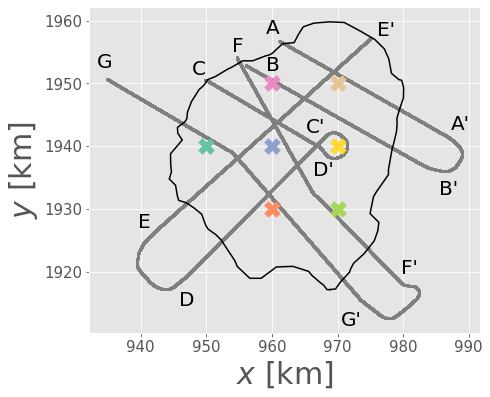

In [8]:
# Plot the radar lines

colors = plt.cm.viridis_r(np.linspace(0,0.95,8))
colors2 = sns.color_palette("Set2").as_hex()

fig, ax = plt.subplots(1, 1, figsize=(7, 6))
ax.scatter(dataXY['psX']/1000, dataXY['psY']/1000, s=5, color='grey')

#for i in range(1,8):
#    ax.scatter(dataXY['psX'][CSs['CS' + str(i)][0]:CSs['CS' + str(i)][1]]/1000, dataXY['psY'][CSs['CS' + str(i)][0]:CSs['CS' + str(i)][1]]/1000, color=colors[i], zorder=1) 
ax.plot(hull_pts[0], hull_pts[1], color='black')
ax.set_xlabel('$x$ [km]', fontsize = 30)
ax.set_ylabel('$y$ [km]', fontsize = 30)
ax.tick_params(axis='both', which='major', labelsize=15)
    
ax.text(0.47, 0.935, "A", size=20, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
ax.text(0.95, 0.64, "A'", size=20, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
ax.text(0.47, 0.82, "B", size=20, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
ax.text(0.92, 0.44, "B'", size=20, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
ax.text(0.28, 0.81, "C", size=20, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
ax.text(0.58, 0.63, "C'", size=20, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
ax.text(0.25, 0.1, "D", size=20, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
ax.text(0.6, 0.5, "D'", size=20, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
ax.text(0.14, 0.34, "E", size=20, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
ax.text(0.76, 0.93, "E'", size=20, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
ax.text(0.38, 0.88, "F", size=20, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
ax.text(0.82, 0.2, "F'", size=20, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
ax.text(0.04, 0.83, "G", size=20, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
ax.text(0.67, 0.04, "G'", size=20, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

ax.scatter(950, 1940, marker='X', color=colors2[0], s=250)
ax.scatter(960, 1930, marker='X', color=colors2[1], s=250)
ax.scatter(960, 1940, marker='X', color=colors2[2], s=250)
ax.scatter(960, 1950, marker='X', color=colors2[3], s=250)
ax.scatter(970, 1930, marker='X', color=colors2[4], s=250)
ax.scatter(970, 1940, marker='X', color=colors2[5], s=250)
ax.scatter(970, 1950, marker='X', color=colors2[6], s=250)

fig.savefig('../Figures/VerticalProfileLocations.jpg', format='jpg', dpi=700, bbox_inches = "tight")


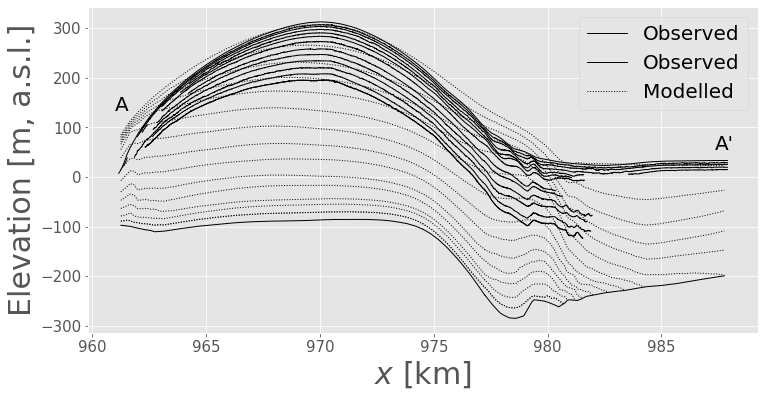

In [9]:
# Plot the first set of data

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
for i in range(1,13):
    ax.plot(radardata['data1']['psX']/1000, radardata['data1']['StratElev' + str(i)], color='black', linewidth=1)
ax.plot(radardata['data1']['psX']/1000, radardata['data1']['StratElev' + str(i)], color='black', linewidth=1, label = 'Observed')
ax.plot(radardata['data1']['psX']/1000, radardata['data1']['Surface'], color='black', linewidth=1, label = 'Observed')

for i in ages:
    data = pd.read_csv('../Simulations/DerwaelSimulations/Contours/' + str(sim_name) + '/ModelledSegment1.csv', sep=",")
    df = data.loc[data['age'] == i]
    df = df.sort_values(by='Points:0')
    ax.plot(df['Points:0']/1000, df['Points:2'], color='black', linestyle='dotted', linewidth=1)
ax.plot(df['Points:0']/1000, df['Points:2'], color='black', linestyle='dotted', linewidth=1, label = 'Modelled')
LSdata = pd.read_csv('../Simulations/DerwaelSimulations/Contours/' + str(sim_name) + '/LS1.csv', sep=",")
LSdata = LSdata.sort_values(by='Points:0')
ax.plot(LSdata['Points:0']/1000, LSdata['Points:2'], linewidth=1, color='black')
# Plot the radar lines in the horizontal    

ax.set_xlabel('$x$ [km]', fontsize = 30)
ax.set_ylabel('Elevation [m, a.s.l.]', fontsize = 30)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.legend(fontsize = 20)
ax.text(0.05, 0.7, "A", size=20, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
ax.text(0.95, 0.58, "A'", size=20, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

fig.savefig('../Figures/StratigraphyComparison/StratigraphyComparison_' + str(sim_name) + '_1.jpg', format='jpg', dpi=700, bbox_inches = "tight")


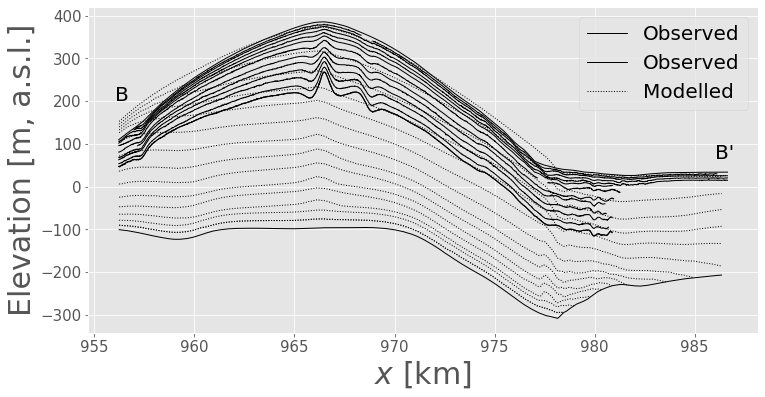

In [10]:
# Plot the second set of data

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
for i in range(1,13):
    ax.plot(radardata['data2']['psX']/1000, radardata['data2']['StratElev' + str(i)], color='black', linewidth=1)
ax.plot(radardata['data2']['psX']/1000, radardata['data2']['StratElev' + str(i)], color='black', linewidth=1, label = 'Observed')
ax.plot(radardata['data2']['psX']/1000, radardata['data2']['Surface'], color='black', linewidth=1, label = 'Observed')

for i in ages:
    data = pd.read_csv('../Simulations/DerwaelSimulations/Contours/' + str(sim_name) + '/ModelledSegment2.csv', sep=",")
    df = data.loc[data['age'] == i]
    df = df.sort_values(by='Points:0')
    ax.plot(df['Points:0']/1000, df['Points:2'], color='black', linestyle='dotted', linewidth=1)
ax.plot(df['Points:0']/1000, df['Points:2'], color='black', linestyle='dotted', linewidth=1, label = 'Modelled')
LSdata = pd.read_csv('../Simulations/DerwaelSimulations/Contours/' + str(sim_name) + '/LS2.csv', sep=",")
LSdata = LSdata.sort_values(by='Points:0')
ax.plot(LSdata['Points:0']/1000, LSdata['Points:2'], linewidth=1, color='black')
ax.set_xlabel('$x$ [km]', fontsize = 30)
ax.set_ylabel('Elevation [m, a.s.l.]', fontsize = 30)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.legend(fontsize = 20)
ax.text(0.05, 0.73, "B", size=20, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
ax.text(0.95, 0.55, "B'", size=20, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

fig.savefig('../Figures/StratigraphyComparison/StratigraphyComparison_' + str(sim_name) + '_2.jpg', format='jpg', dpi=700, bbox_inches = "tight")


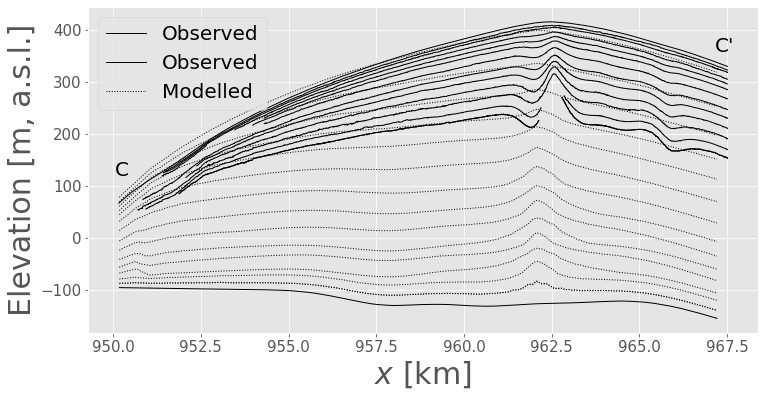

In [11]:
# Plot the third set of data

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
for i in range(1,13):
    ax.plot(radardata['data3']['psX']/1000, radardata['data3']['StratElev' + str(i)], color='black', linewidth=1)
ax.plot(radardata['data3']['psX']/1000, radardata['data3']['StratElev' + str(i)], color='black', linewidth=1, label = 'Observed')
ax.plot(radardata['data3']['psX']/1000, radardata['data3']['Surface'], color='black', linewidth=1, label = 'Observed')

for i in ages:
    data = pd.read_csv('../Simulations/DerwaelSimulations/Contours/' + str(sim_name) + '/ModelledSegment3.csv', sep=",")
    df = data.loc[data['age'] == i]
    df = df.sort_values(by='Points:0')
    ax.plot(df['Points:0']/1000, df['Points:2'], color='black', linestyle='dotted', linewidth=1)
ax.plot(df['Points:0']/1000, df['Points:2'], color='black', linestyle='dotted', linewidth=1, label = 'Modelled')
LSdata = pd.read_csv('../Simulations/DerwaelSimulations/Contours/' + str(sim_name) + '/LS3.csv', sep=",")
LSdata = LSdata.sort_values(by='Points:0')
ax.plot(LSdata['Points:0']/1000, LSdata['Points:2'], linewidth=1, color='black')
ax.set_xlabel('$x$ [km]', fontsize = 30)
ax.set_ylabel('Elevation [m, a.s.l.]', fontsize = 30)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.legend(fontsize = 20)
ax.text(0.05, 0.5, "C", size=20, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
ax.text(0.95, 0.88, "C'", size=20, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

fig.savefig('../Figures/StratigraphyComparison/StratigraphyComparison_' + str(sim_name) + '_3.jpg', format='jpg', dpi=700, bbox_inches = "tight")


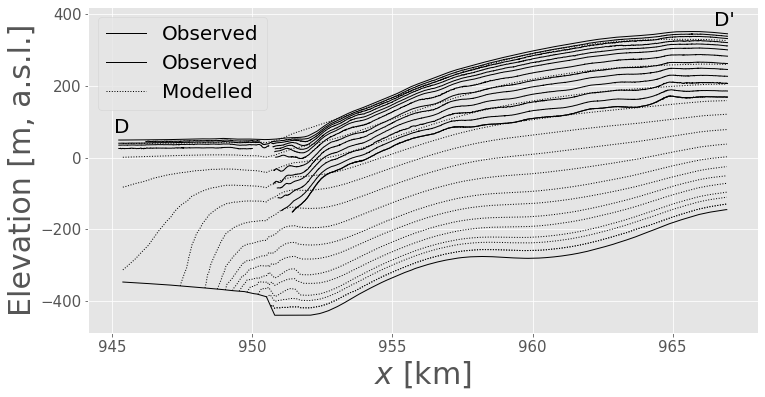

In [12]:
# Plot the fourth set of data

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
for i in range(1,13):
    ax.plot(radardata['data4']['psX']/1000, radardata['data4']['StratElev' + str(i)], color='black', linewidth=1)
ax.plot(radardata['data4']['psX']/1000, radardata['data4']['StratElev' + str(i)], color='black', linewidth=1, label = 'Observed')
ax.plot(radardata['data4']['psX']/1000, radardata['data4']['Surface'], color='black', linewidth=1, label = 'Observed')

for i in ages:
    data = pd.read_csv('../Simulations/DerwaelSimulations/Contours/' + str(sim_name) + '/ModelledSegment4.csv', sep=",")
    df = data.loc[data['age'] == i]
    df = df.sort_values(by='Points:0')
    ax.plot(df['Points:0']/1000, df['Points:2'], color='black', linestyle='dotted', linewidth=1)
ax.plot(df['Points:0']/1000, df['Points:2'], color='black', linestyle='dotted', linewidth=1, label = 'Modelled')
LSdata = pd.read_csv('../Simulations/DerwaelSimulations/Contours/' + str(sim_name) + '/LS4.csv', sep=",")
LSdata = LSdata.sort_values(by='Points:0')
ax.plot(LSdata['Points:0']/1000, LSdata['Points:2'], linewidth=1, color='black')
ax.set_xlabel('$x$ [km]', fontsize = 30)
ax.set_ylabel('Elevation [m, a.s.l.]', fontsize = 30)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.legend(fontsize = 20)
plt.ylim(-490, 420)
ax.text(0.05, 0.63, "D", size=20, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
ax.text(0.95, 0.96, "D'", size=20, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

fig.savefig('../Figures/StratigraphyComparison/StratigraphyComparison_' + str(sim_name) + '_4.jpg', format='jpg', dpi=700, bbox_inches = "tight")


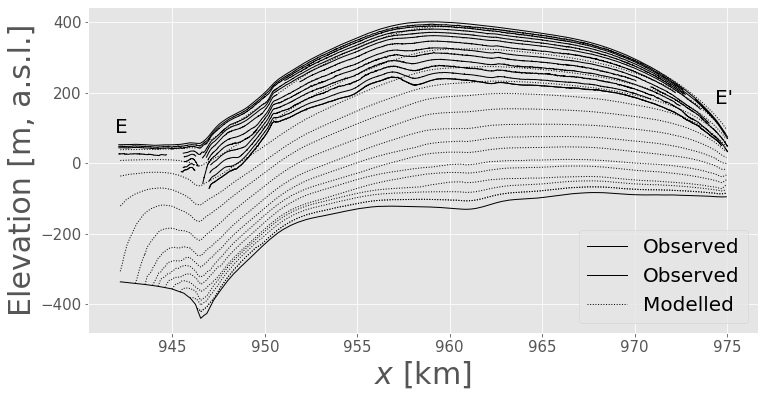

In [13]:
# Plot the fifth set of data

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
for i in range(1,13):
    ax.plot(radardata['data5']['psX']/1000, radardata['data5']['StratElev' + str(i)], color='black', linewidth=1)
ax.plot(radardata['data5']['psX']/1000, radardata['data5']['StratElev' + str(i)], color='black', linewidth=1, label = 'Observed')
ax.plot(radardata['data5']['psX']/1000, radardata['data5']['Surface'], color='black', linewidth=1, label = 'Observed')

for i in ages:
    data = pd.read_csv('../Simulations/DerwaelSimulations/Contours/' + str(sim_name) + '/ModelledSegment5.csv', sep=",")
    df = data.loc[data['age'] == i]
    df = df.sort_values(by='Points:0')
    ax.plot(df['Points:0']/1000, df['Points:2'], color='black', linestyle='dotted', linewidth=1)
ax.plot(df['Points:0']/1000, df['Points:2'], color='black', linestyle='dotted', linewidth=1, label = 'Modelled')
LSdata = pd.read_csv('../Simulations/DerwaelSimulations/Contours/' + str(sim_name) + '/LS5.csv', sep=",")
LSdata = LSdata.sort_values(by='Points:0')
ax.plot(LSdata['Points:0']/1000, LSdata['Points:2'], linewidth=1, color='black')
ax.set_xlabel('$x$ [km]', fontsize = 30)
ax.set_ylabel('Elevation [m, a.s.l.]', fontsize = 30)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.legend(fontsize = 20)
ax.text(0.05, 0.63, "E", size=20, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
ax.text(0.95, 0.72, "E'", size=20, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

fig.savefig('../Figures/StratigraphyComparison/StratigraphyComparison_' + str(sim_name) + '_5.jpg', format='jpg', dpi=700, bbox_inches = "tight")


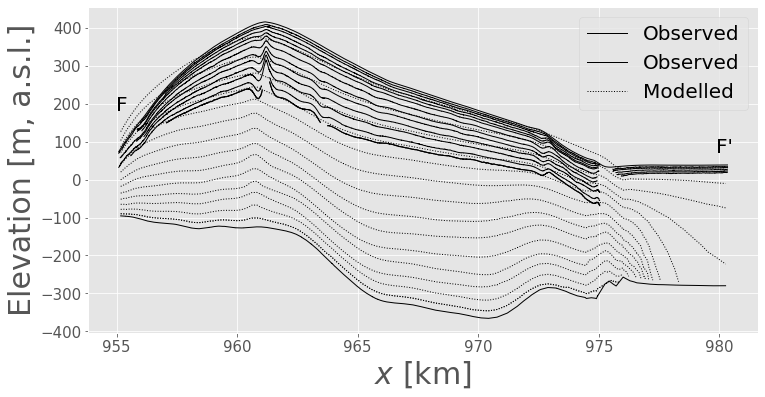

In [14]:
# Plot the sixth set of data

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
for i in range(1,13):
    ax.plot(radardata['data6']['psX']/1000, radardata['data6']['StratElev' + str(i)], color='black', linewidth=1)
ax.plot(radardata['data6']['psX']/1000, radardata['data6']['StratElev' + str(i)], color='black', linewidth=1, label = 'Observed')
ax.plot(radardata['data6']['psX']/1000, radardata['data6']['Surface'], color='black', linewidth=1, label = 'Observed')

for i in ages:
    data = pd.read_csv('../Simulations/DerwaelSimulations/Contours/n3E0.6/ModelledSegment6.csv', sep=",")
    df = data.loc[data['age'] == i]
    df = df.sort_values(by='Points:0')
    ax.plot(df['Points:0']/1000, df['Points:2'], color='black', linestyle='dotted', linewidth=1)
ax.plot(df['Points:0']/1000, df['Points:2'], color='black', linestyle='dotted', linewidth=1, label = 'Modelled')
LSdata = pd.read_csv('../Simulations/DerwaelSimulations/Contours/' + str(sim_name) + '/LS6.csv', sep=",")
LSdata = LSdata.sort_values(by='Points:0')
ax.plot(LSdata['Points:0']/1000, LSdata['Points:2'], linewidth=1, color='black')
ax.set_xlabel('$x$ [km]', fontsize = 30)
ax.set_ylabel('Elevation [m, a.s.l.]', fontsize = 30)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.legend(fontsize = 20)
ax.text(0.05, 0.7, "F", size=20, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
ax.text(0.95, 0.57, "F'", size=20, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

fig.savefig('../Figures/StratigraphyComparison/StratigraphyComparison_' + str(sim_name) + '_6.jpg', format='jpg', dpi=700, bbox_inches = "tight")


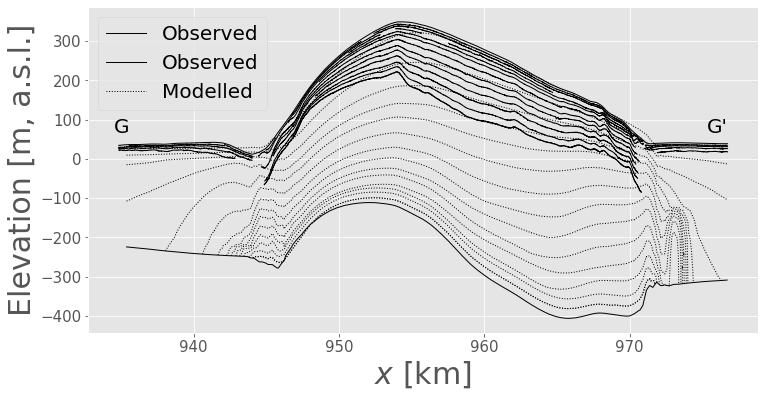

In [15]:
# Plot the seventh set of data

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
for i in range(1,13):
    ax.plot(radardata['data7']['psX']/1000, radardata['data7']['StratElev' + str(i)], color='black', linewidth=1)
ax.plot(radardata['data7']['psX']/1000, radardata['data7']['StratElev' + str(i)], color='black', linewidth=1, label = 'Observed')
ax.plot(radardata['data7']['psX']/1000, radardata['data7']['Surface'], color='black', linewidth=1, label = 'Observed')
   
for i in ages:
    data = pd.read_csv('../Simulations/DerwaelSimulations/Contours/' + str(sim_name) + '/ModelledSegment7.csv', sep=",")
    df = data.loc[data['age'] == i]
    df = df.sort_values(by='Points:0')
    ax.plot(df['Points:0']/1000, df['Points:2'], color='black', linestyle='dotted', linewidth=1)
ax.plot(df['Points:0']/1000, df['Points:2'], color='black', linestyle='dotted', linewidth=1, label = 'Modelled')
LSdata = pd.read_csv('../Simulations/DerwaelSimulations/Contours/' + str(sim_name) + '/LS7.csv', sep=",")
LSdata = LSdata.sort_values(by='Points:0')
ax.plot(LSdata['Points:0']/1000, LSdata['Points:2'], linewidth=1, color='black')
ax.set_xlabel('$x$ [km]', fontsize = 30)
ax.set_ylabel('Elevation [m, a.s.l.]', fontsize = 30)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.legend(fontsize = 20)
ax.text(0.05, 0.63, "G", size=20, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
ax.text(0.94, 0.63, "G'", size=20, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

fig.savefig('../Figures/StratigraphyComparison/StratigraphyComparison_' + str(sim_name) + '_7.jpg', format='jpg', dpi=700, bbox_inches = "tight")


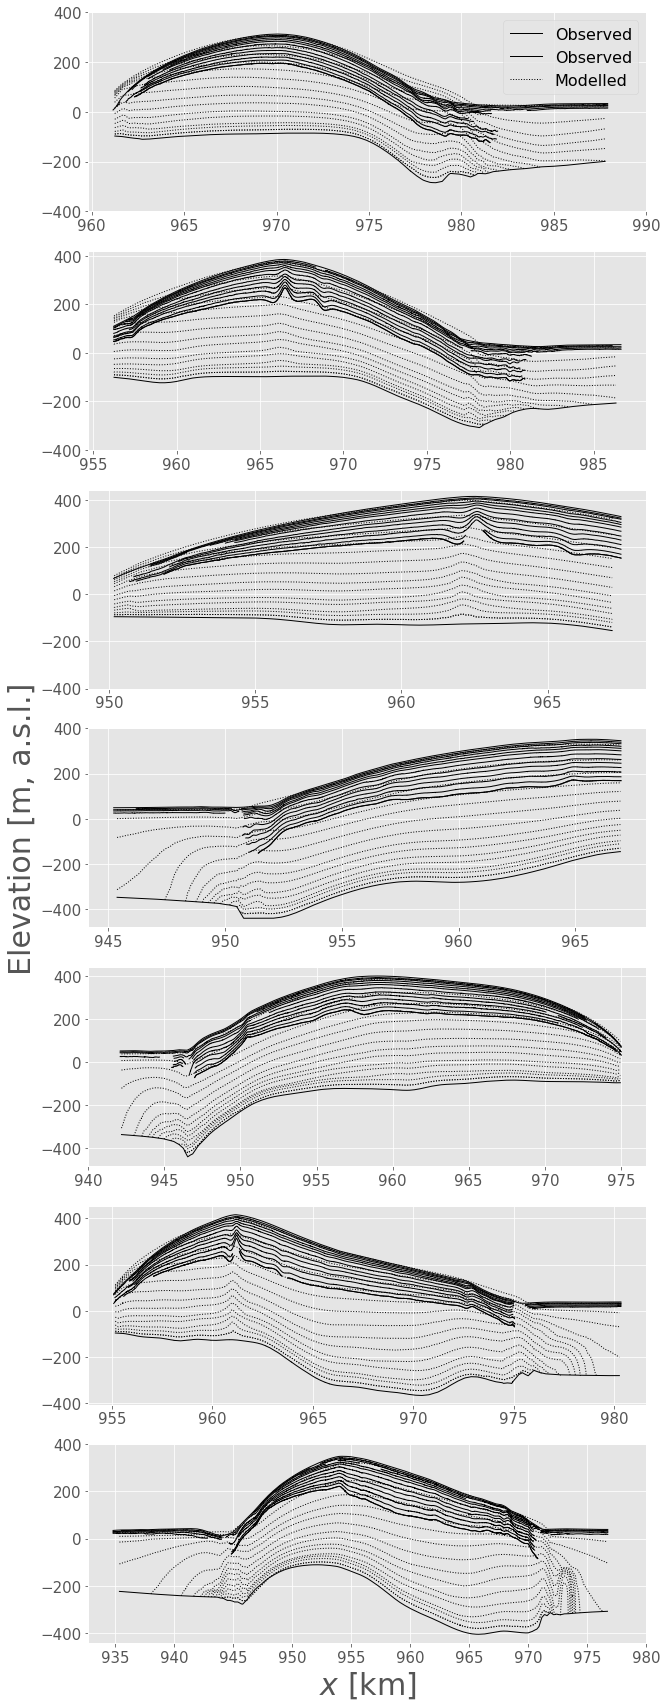

In [16]:

fig, ax = plt.subplots(7, 1, figsize=(10, 30))
for j in range(1,8):
    for i in range(1,13):
        ax[j-1].plot(radardata['data' + str(j)]['psX']/1000, radardata['data' + str(j)]['StratElev' + str(i)], color='black', linewidth=1)
    ax[j-1].plot(radardata['data' + str(j)]['psX']/1000, radardata['data' + str(j)]['StratElev' + str(i)], color='black', linewidth=1, label = 'Observed')
    ax[j-1].plot(radardata['data' + str(j)]['psX']/1000, radardata['data' + str(j)]['Surface'], color='black', linewidth=1, label = 'Observed')

    for i in ages:
        data = pd.read_csv('../Simulations/DerwaelSimulations/Contours/' + str(sim_name) + '/ModelledSegment' + str(j) + '.csv', sep=",")
        df = data.loc[data['age'] == i]
        df = df.sort_values(by='Points:0')
        ax[j-1].plot(df['Points:0']/1000, df['Points:2'], color='black', linestyle='dotted', linewidth=1)
    ax[j-1].plot(df['Points:0']/1000, df['Points:2'], color='black', linestyle='dotted', linewidth=1, label = 'Modelled')
    LSdata = pd.read_csv('../Simulations/DerwaelSimulations/Contours/' + str(sim_name) + '/LS' + str(j) + '.csv', sep=",")
    LSdata = LSdata.sort_values(by='Points:0')
    ax[j-1].plot(LSdata['Points:0']/1000, LSdata['Points:2'], linewidth=1, color='black')
    ax[j-1].tick_params(axis='both', which='major', labelsize=15)
    ax[j-1].set_yticks(np.arange(-400, 600, 200))
ax[3].set_ylabel('Elevation [m, a.s.l.]', fontsize = 30)
ax[6].set_xlabel('$x$ [km]', fontsize = 30)
ax[0].legend(fontsize = 16, loc='upper right')
ax[0].set_xticks(np.arange(960, 995, 5))
ax[1].set_xticks(np.arange(955, 990, 5))
ax[2].set_xticks(np.arange(950, 970, 5))
ax[3].set_xticks(np.arange(945, 970, 5))
ax[4].set_xticks(np.arange(940, 980, 5))
ax[5].set_xticks(np.arange(955, 985, 5))
ax[6].set_xticks(np.arange(935, 985, 5))
#fig.savefig('../Figures/StratigraphyComparison/StratigraphyComparison_' + str(sim_name) + '_Combined.jpg', format='jpg', dpi=700, bbox_inches = "tight")


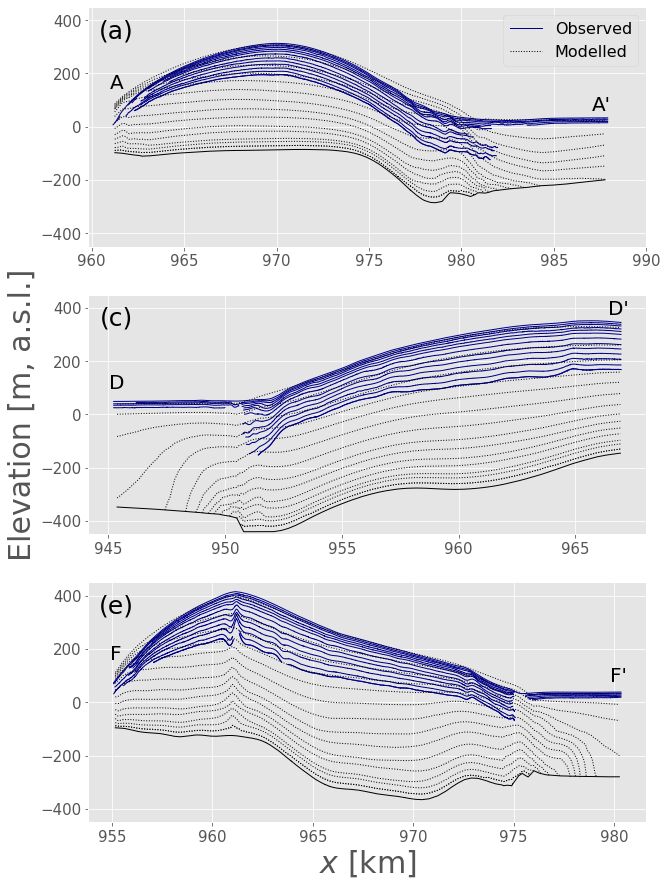

In [20]:

fig, ax = plt.subplots(3, 1, figsize=(10, 15))
lst = [0, 3, 5]
for j in range(0,3):
    for i in range(1,13):
        ax[j].plot(radardata['data' + str(lst[j]+1)]['psX']/1000, radardata['data' + str(lst[j]+1)]['StratElev' + str(i)], color='darkblue', linewidth=1)
    ax[j].plot(radardata['data' + str(lst[j]+1)]['psX']/1000, radardata['data' + str(lst[j]+1)]['StratElev' + str(i)], color='darkblue', linewidth=1, label = 'Observed')
    ax[j].plot(radardata['data' + str(lst[j]+1)]['psX']/1000, radardata['data' + str(lst[j]+1)]['Surface'], color='darkblue', linewidth=1)

    for i in ages:
        data = pd.read_csv('../Simulations/DerwaelSimulations/Contours/' + str(sim_name) + '/ModelledSegment' + str(lst[j]+1) + '.csv', sep=",")
        df = data.loc[data['age'] == i]
        df = df.sort_values(by='Points:0')
        ax[j].plot(df['Points:0']/1000, df['Points:2'], color='black', linestyle='dotted', linewidth=1)
    ax[j].plot(df['Points:0']/1000, df['Points:2'], color='black', linestyle='dotted', linewidth=1, label = 'Modelled')
    LSdata = pd.read_csv('../Simulations/DerwaelSimulations/Contours/' + str(sim_name) + '/LS' + str(lst[j]+1) + '.csv', sep=",")
    LSdata = LSdata.sort_values(by='Points:0')
    ax[j].plot(LSdata['Points:0']/1000, LSdata['Points:2'], linewidth=1, color='black')
    ax[j].tick_params(axis='both', which='major', labelsize=15)
    ax[j].set_yticks(np.arange(-400, 600, 200))
    ax[j].set_ylim(-450, 450)
ax[1].set_ylabel('Elevation [m, a.s.l.]', fontsize = 30)
ax[2].set_xlabel('$x$ [km]', fontsize = 30)
ax[0].legend(fontsize = 16, loc='upper right')
ax[0].set_xticks(np.arange(960, 995, 5))
ax[1].set_xticks(np.arange(945, 970, 5))
ax[2].set_xticks(np.arange(955, 985, 5))
ax[0].text(0.05, 0.68, "A", size=20, horizontalalignment='center', verticalalignment='center', transform=ax[0].transAxes)
ax[0].text(0.92, 0.59, "A'", size=20, horizontalalignment='center', verticalalignment='center', transform=ax[0].transAxes)
ax[1].text(0.05, 0.63, "D", size=20, horizontalalignment='center', verticalalignment='center', transform=ax[1].transAxes)
ax[1].text(0.95, 0.94, "D'", size=20, horizontalalignment='center', verticalalignment='center', transform=ax[1].transAxes)
ax[2].text(0.05, 0.7, "F", size=20, horizontalalignment='center', verticalalignment='center', transform=ax[2].transAxes)
ax[2].text(0.95, 0.61, "F'", size=20, horizontalalignment='center', verticalalignment='center', transform=ax[2].transAxes)

ax[0].text(0.05, 0.9, "(a)", size=25, horizontalalignment='center', verticalalignment='center', transform=ax[0].transAxes)
ax[1].text(0.05, 0.9, "(c)", size=25, horizontalalignment='center', verticalalignment='center', transform=ax[1].transAxes)
ax[2].text(0.05, 0.9, "(e)", size=25, horizontalalignment='center', verticalalignment='center', transform=ax[2].transAxes)

fig.savefig('../Figures/StratigraphyComparison/StratigraphyComparison_' + str(sim_name) + '_Combined.jpg', format='jpg', dpi=700, bbox_inches = "tight")


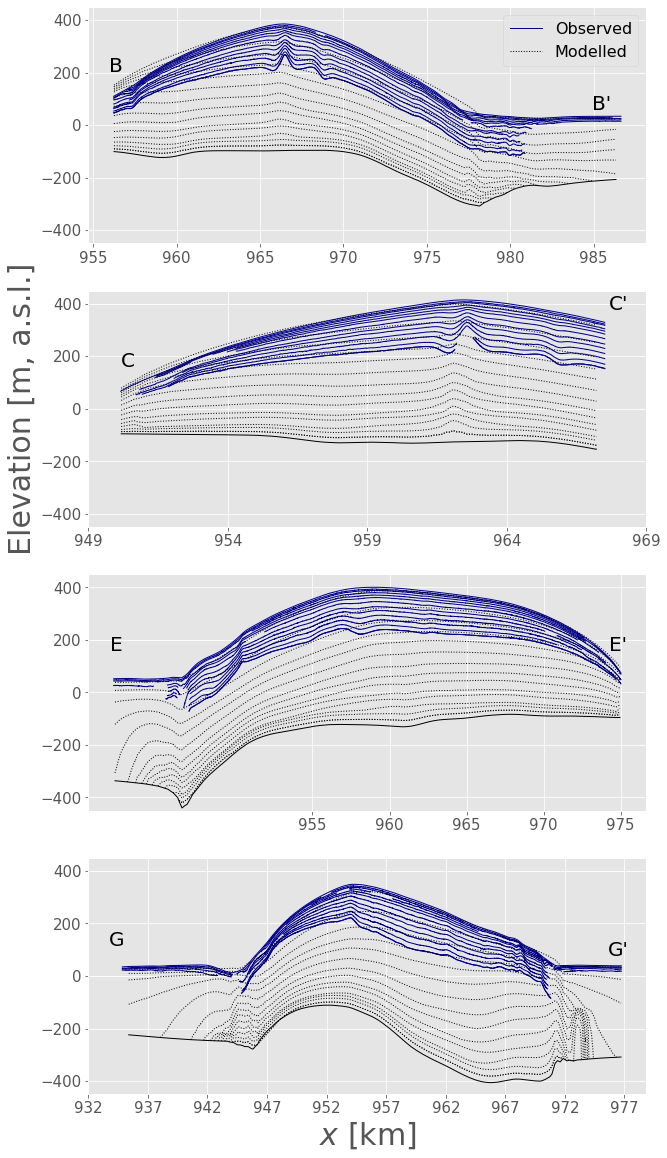

In [36]:

fig, ax = plt.subplots(4, 1, figsize=(10, 20))
lst = [1, 2, 4, 6]
for j in range(0,4):
    for i in range(1,13):
        ax[j].plot(radardata['data' + str(lst[j]+1)]['psX']/1000, radardata['data' + str(lst[j]+1)]['StratElev' + str(i)], color='darkblue', linewidth=1)
    ax[j].plot(radardata['data' + str(lst[j]+1)]['psX']/1000, radardata['data' + str(lst[j]+1)]['StratElev' + str(i)], color='darkblue', linewidth=1, label = 'Observed')
    ax[j].plot(radardata['data' + str(lst[j]+1)]['psX']/1000, radardata['data' + str(lst[j]+1)]['Surface'], color='darkblue', linewidth=1)

    for i in ages:
        data = pd.read_csv('../Simulations/DerwaelSimulations/Contours/' + str(sim_name) + '/ModelledSegment' + str(lst[j]+1) + '.csv', sep=",")
        df = data.loc[data['age'] == i]
        df = df.sort_values(by='Points:0')
        ax[j].plot(df['Points:0']/1000, df['Points:2'], color='black', linestyle='dotted', linewidth=1)
    ax[j].plot(df['Points:0']/1000, df['Points:2'], color='black', linestyle='dotted', linewidth=1, label = 'Modelled')
    LSdata = pd.read_csv('../Simulations/DerwaelSimulations/Contours/' + str(sim_name) + '/LS' + str(lst[j]+1) + '.csv', sep=",")
    LSdata = LSdata.sort_values(by='Points:0')
    ax[j].plot(LSdata['Points:0']/1000, LSdata['Points:2'], linewidth=1, color='black')
    ax[j].tick_params(axis='both', which='major', labelsize=15)
    ax[j].set_yticks(np.arange(-400, 600, 200))
    ax[j].set_ylim(-450, 450)
ax[1].set_ylabel('Elevation [m, a.s.l.]', fontsize = 30)
ax[3].set_xlabel('$x$ [km]', fontsize = 30)
ax[0].legend(fontsize = 16, loc='upper right')

ax[0].set_xticks(np.arange(955, 990, 5))
ax[1].set_xticks(np.arange(949, 970, 5))
ax[2].set_xticks(np.arange(955, 978, 5))
ax[3].set_xticks(np.arange(932, 980, 5))

ax[0].text(0.05, 0.75, "B", size=20, horizontalalignment='center', verticalalignment='center', transform=ax[0].transAxes)
ax[0].text(0.92, 0.59, "B'", size=20, horizontalalignment='center', verticalalignment='center', transform=ax[0].transAxes)
ax[1].text(0.07, 0.7, "C", size=20, horizontalalignment='center', verticalalignment='center', transform=ax[1].transAxes)
ax[1].text(0.95, 0.94, "C'", size=20, horizontalalignment='center', verticalalignment='center', transform=ax[1].transAxes)
ax[2].text(0.05, 0.7, "E", size=20, horizontalalignment='center', verticalalignment='center', transform=ax[2].transAxes)
ax[2].text(0.95, 0.7, "E'", size=20, horizontalalignment='center', verticalalignment='center', transform=ax[2].transAxes)
ax[3].text(0.05, 0.65, "G", size=20, horizontalalignment='center', verticalalignment='center', transform=ax[3].transAxes)
ax[3].text(0.95, 0.61, "G'", size=20, horizontalalignment='center', verticalalignment='center', transform=ax[3].transAxes)

#ax[0].text(0.05, 0.9, "", size=25, horizontalalignment='center', verticalalignment='center', transform=ax[0].transAxes)
#ax[1].text(0.05, 0.9, "(c)", size=25, horizontalalignment='center', verticalalignment='center', transform=ax[1].transAxes)
#ax[2].text(0.05, 0.9, "(e)", size=25, horizontalalignment='center', verticalalignment='center', transform=ax[2].transAxes)

fig.savefig('../Figures/StratigraphyComparison/StratigraphyComparison_extra_' + str(sim_name) + '_Combined.jpg', format='jpg', dpi=700, bbox_inches = "tight")
